# Github Activity Metrics-Issues

**Activity by Repo**

This notebook will aim to query the Augur DB to access the neccessary information to be able to get the following issue metrics dirived from the GitHub Community Metrics working document https://docs.google.com/document/d/1Yocr6fk0J8EsVZnJwoIl3kRQaI94tI-XHe7VSMFT0yM/edit?usp=sharing

Any necessary computations from the data to get the metric value will be done as the queries are determined

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)

with open("../config_temp.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
#add your repo name(s) here of the repo(s) you want to query if known (and in the database)
repo_name_set = ['augur', 'grimoirelab']
repo_set = []

for repo_name in repo_name_set:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_name = \'{repo_name}\'
        """)

    t = engine.execute(repo_query)
    repo_id =t.mappings().all()[0].get('repo_id')
    repo_set.append(repo_id)
print(repo_set)

[25440, 25448]


In [4]:
#Take this out of quotes if you want to manually assign a repo_id number(s)
#repo_set = [25440]

## Gather and Process Data

### Query

In [5]:
df_issues = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    r.repo_name,
					i.issue_id AS issue, 
					i.gh_issue_number AS issue_number,
					i.gh_issue_id AS gh_issue,
					i.created_at AS created, 
					i.closed_at AS closed
                FROM
                	repo r,
                    issues i
                WHERE
                	r.repo_id = i.repo_id AND
                    i.repo_id = \'{repo_id}\'
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_issues = pd.concat([df_issues, df_current_repo])

df_issues = df_issues.reset_index()
df_issues.drop("index", axis=1, inplace=True)
        
df_issues

,repo_name,issue,issue_number,gh_issue,created,closed
0,augur,340115,28,213149529,2017-03-09 20:06:18,2017-04-07 21:18:01
1,augur,343231,886,682259157,2020-08-20 00:09:30,2020-08-20 00:16:50
2,augur,343216,880,679627659,2020-08-15 19:11:45,2020-08-17 14:30:04
3,augur,343467,967,724668885,2020-10-19 14:21:08,2020-10-19 14:21:34
4,augur,342738,740,628534692,2020-06-01 15:34:33,2020-08-20 10:48:14
...,...,...,...,...,...,...
1855,grimoirelab,735294,437,941801983,2021-07-12 08:23:29,2021-07-28 08:58:49
1856,grimoirelab,735295,436,924259145,2021-06-17 19:24:54,NaT
1857,grimoirelab,340606,284,559853733,2020-02-04 17:00:31,NaT
1858,grimoirelab,734649,429,889819068,2021-05-12 08:28:28,NaT


In [6]:
#IF YOU ONLY WANT TO LOOK AT A ONE OF THE REPOS QUERIED 
repo_focus = 'augur'
df_issues_focus = df_issues[df_issues['repo_name'] == repo_focus]
df_issues_focus = df_issues_focus.sort_values(by= "created")
df_issues_focus = df_issues_focus.reset_index(drop=True)

## Numer of issues Created 

### By Day

In [7]:
df_issues_daily = df_issues_focus['created'].groupby(df_issues_focus.created.dt.to_period("D")).agg('count')

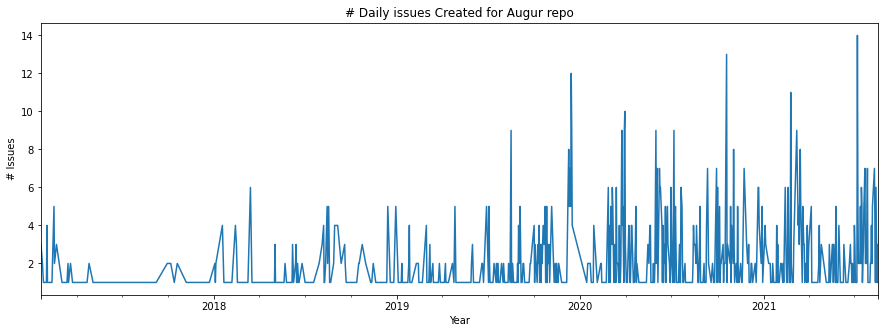

In [8]:
df_issues_daily.plot()

plt.xlabel("Year")
plt.ylabel("# Issues")
plt.title("# Daily issues Created for "+repo_focus.capitalize() +" repo")
plt.show()

### By Week

In [9]:
df_issues_weekly = df_issues_focus['created'].groupby(df_issues_focus.created.dt.to_period("W")).agg('count')

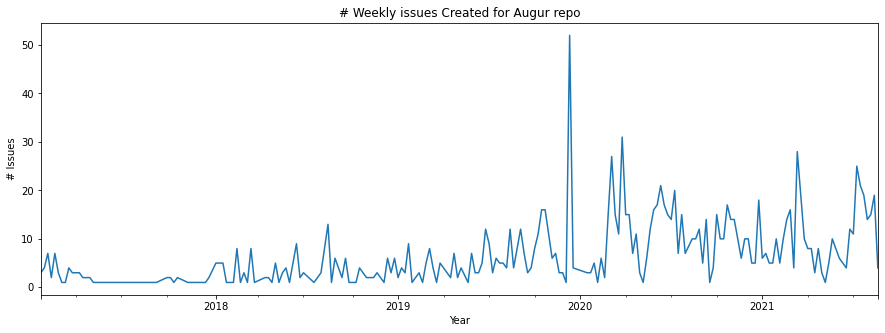

In [10]:
df_issues_weekly.plot()

plt.xlabel("Year")
plt.ylabel("# Issues")
plt.title("# Weekly issues Created for "+repo_focus.capitalize() +" repo")
plt.show()

### By Month

In [11]:
df_issues_monthly = df_issues_focus['created'].groupby(df_issues_focus.created.dt.to_period("M")).agg('count')

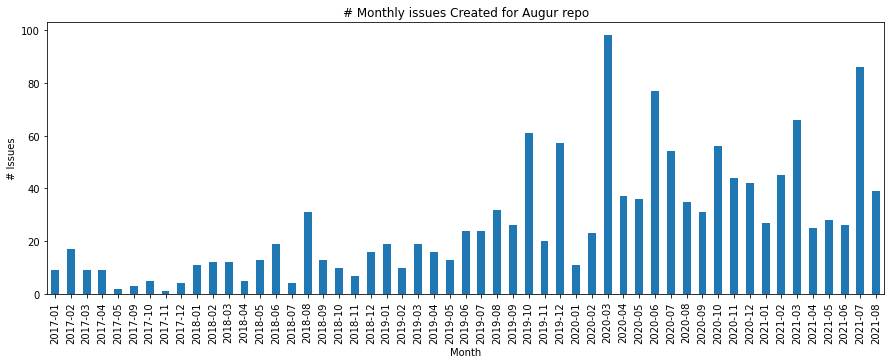

In [12]:
df_issues_monthly.plot.bar()

plt.xlabel("Month")
plt.ylabel("# Issues")
plt.title("# Monthly issues Created for "+repo_focus.capitalize() +" repo")
plt.show()

## Numer of issues closed

### By Day

In [13]:
df_issues_closed_daily = df_issues_focus['closed'].groupby(df_issues_focus.closed.dt.to_period("D")).agg('count')

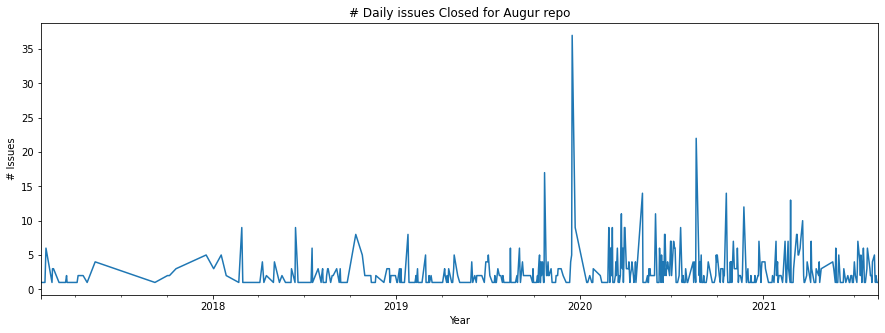

In [14]:
df_issues_closed_daily.plot()

plt.xlabel("Year")
plt.ylabel("# Issues")
plt.title("# Daily issues Closed for "+repo_focus.capitalize() +" repo")
plt.show()

### By Week

In [15]:
df_issues_closed_weekly = df_issues_focus['closed'].groupby(df_issues_focus.closed.dt.to_period("W")).agg('count')

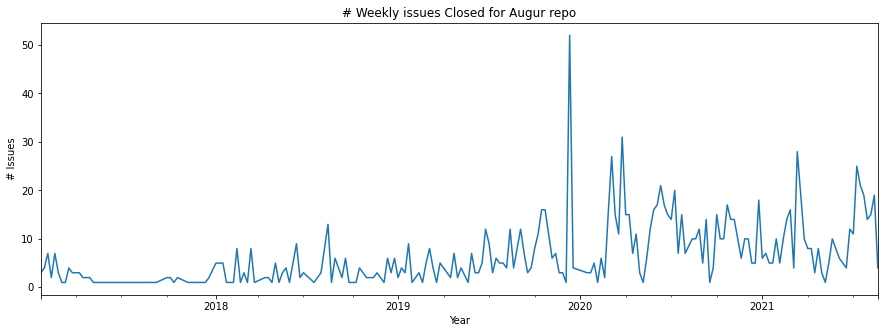

In [16]:
df_issues_weekly.plot()

plt.xlabel("Year")
plt.ylabel("# Issues")
plt.title("# Weekly issues Closed for "+ repo_focus.capitalize() +" repo")
plt.show()

### By Month

In [17]:
df_issues_closed_monthly = df_issues_focus['closed'].groupby(df_issues_focus.closed.dt.to_period("M")).agg('count')

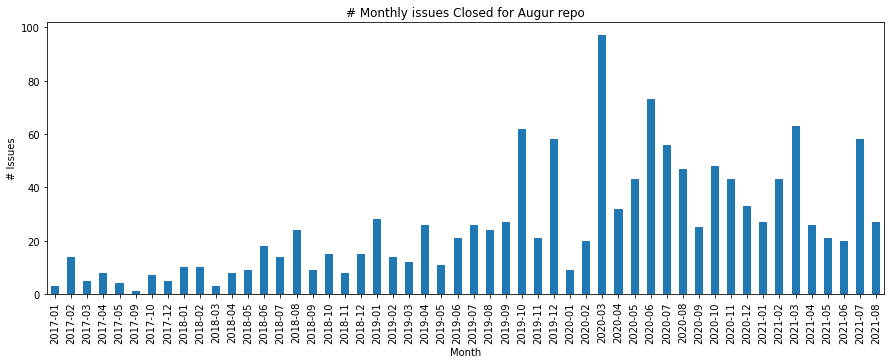

In [18]:
df_issues_closed_monthly.plot.bar()

plt.xlabel("Month")
plt.ylabel("# Issues")
plt.title("# Monthly issues Closed for "+repo_focus.capitalize() +" repo")
plt.show()